In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import os
from data_preprocessing import FilteringCurves, ShowResponseCurves
from fitting_curves import FittingColumn, ShowResponseCurvesWithFitting
_FOLDER = "../data/"

### Coding Part

In [2]:
def FittedData(df, x_columns, y_columns, fitting_function, parameters_guess=[], default_param = True):
    
    r2, fit_param = FittingColumn(df, df.index, x_columns, y_columns, fitting_function, default_param = True)
    df["fitting_r2"] = r2
    df["fitting_param"] = fit_param
    df= df[df["fitting_r2"]!=0]
    return df

def TransposeCellFeatures(df, indexes_first_column = True):
    # columns in cell_features correspond to drug_curves["COSMIC_ID"] == cell line id
    if indexes_first_column:
        df_transfromed = pd.DataFrame(data= df[df.columns[1:]].values.T,
                          index= df.columns[1:], columns= df[df.columns[0]].values)
    else:
        print("The logic of this function is not applicable")
        
    return df_transfromed 

def PrepareDrugMerge(df):
    """Column fitting_param is splitted into separate columns """
    conc_columns= ["fd_num_"+str(i) for i in range(10)]
    response_norm = ['norm_cells_'+str(i) for i in range(10)]
    param_cols = ["DRUG_ID"] + conc_columns + response_norm
    for i in range(len(df['fitting_param'].values[0])):
        param_col = "param_"+str(i+1)
        param_cols.append(param_col)
        df[param_col] = df['fitting_param'].apply(lambda x: x[i])
    param_cols.insert(0, "COSMIC_ID")
    return df[param_cols]
    

def MergeDrugCells(df_drugs, df_cells):
    cell_features_T = TransposeCellFeatures(df_cells)
    cell_features_T.index = np.array(cell_features_T.index, dtype = "int")
    
    # Not all the drugs from filtered dataset are present in cell lines features
    common_cells_drug = list(set(np.array(df_cells.columns[1:], dtype="int"))& set(df_drugs["COSMIC_ID"].values))
    
    # print("Number of drugs in filtered dataset:", df_328["COSMIC_ID"].nunique())
    # print("Number of common drugs in both datasets", len(common_cells_drug328))

    cell_lines = cell_features_T.loc[common_cells_drug, :].reset_index()
    cell_lines.rename(columns = {"index": "COSMIC_ID"}, inplace=True)
    
    df_drug_param = PrepareDrugMerge(df_drugs)
    
    # merge drug profile data (fitted parameters) and cell line features
    return pd.merge(left=df_drug_param, right = cell_lines, on = "COSMIC_ID") 

conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

### Fitting data with Preview of the results

In [3]:
# NEED TO CHANGE - what file to read
drug_df = pd.read_csv("../results/filtered_drug_profiles_123.csv")
drug_df.shape

(2776, 47)

In [4]:
# NEED TO CHANGE - what fitting function to use
fitting_function = "sigmoid_4_param"
df = FittedData(drug_df, x_columns=conc_columns, y_columns= response_norm, 
                fitting_function=fitting_function, default_param = True)
print("Fitted data with removed unfit", df.shape)

100%|██████████| 2776/2776 [00:08<00:00, 342.84it/s]

Fitted data with removed unfit (2771, 49)


Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


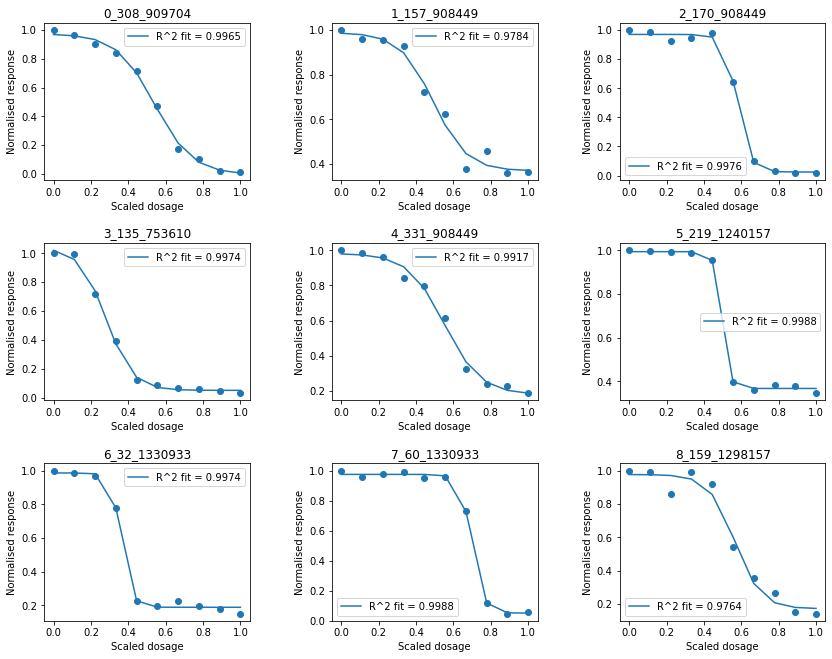

In [5]:
# NEED TO CHANGE - fitting function and resulting fitting columns/column
fitting_function = "sigmoid_4_param"
fit_columns = "fitting_param"

ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, 
                              y_columns = response_norm, indexes=df.index[:9], 
                              fitting_function = fitting_function, fitting_parameters = fit_columns)

In [6]:
# Filtrated and fitted data
print("Filtrated and fitted data:", df.shape)
statistics = df.groupby("DRUG_ID")[["DRUGID_COSMICID"]].count().reset_index().rename(columns= {"DRUGID_COSMICID": "Number_cell_lines"})
# statistics.sort_values("Number_cell_lines", ascending =False).head(10)

drug_features = pd.read_csv(_FOLDER+'/Drug_Features.csv').rename(columns = {"Drug ID": "DRUG_ID"})
pd.merge(left = statistics, right = drug_features, how= "left", on = "DRUG_ID").sort_values("Number_cell_lines", ascending =False).head(10)

Filtrated and fitted data: (2771, 49)


,DRUG_ID,Number_cell_lines,Drug Name,Synonyms,Target,Target Pathway
108,328,118,SNX-2112,SNX 2112,HSP90,Protein stability and degradation
84,272,116,AR-42,"HDAC-42, AR 42, AR42",HDAC1,Chromatin histone acetylation
85,273,115,CUDC-101,CUDC 101,"HDAC1-10, EGFR, ERBB2",Other
86,274,109,Belinostat,"PXD101, PXD-101",HDAC1,Chromatin histone acetylation
88,276,109,CAY10603,-,"HDAC1, HDAC6",Chromatin histone acetylation
40,170,106,Shikonin,Anchusin,not defined,Other
55,200,93,Dacinostat,"NVP-LAQ824, LAQ824",HDAC1,Chromatin histone acetylation
62,219,92,AT-7519,AT7519,"CDK1, CDK2, CDK4, CDK6, CDK9",Cell cycle
47,180,78,Thapsigargin,Octanoic acid,SERCA,Other
113,346,61,THZ-2-102-1,-,CDK7,Cell cycle


### Merging drug profiles with cell lines' properties

In [7]:
"MAX_CONC" in df

True

In [8]:
cell_features = pd.read_csv(_FOLDER+"Cell_Line_Features_PANCAN_simple_MOBEM.tsv", sep="\t")
merged_df = MergeDrugCells(df, cell_features)
merged_df = pd.merge(merged_df, df[["DRUG_ID", "COSMIC_ID", "MAX_CONC"]], on= ["DRUG_ID", "COSMIC_ID"])
merged_df.shape

(2612, 1100)

In [9]:
merged_df.head(5)

,COSMIC_ID,DRUG_ID,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,fd_num_5,fd_num_6,fd_num_7,...,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET,MAX_CONC
0,909704,308,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,0,0,0,0,0,0,0,0,5.120
1,909704,133,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,0,0,0,0,0,0,0,0,1.024
2,909704,328,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,0,0,0,0,0,0,0,0,2.560
3,909704,276,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,0,0,0,0,0,0,0,0,20.000
4,909704,208,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,0,0,0,0,0,0,0,0,0.128


## Merging without preview

In [10]:
os.listdir("../results/")

['drug_cells_kernels_best_parameters.csv',
 'X_features_1122_easy_read.txt',
 'drug_cells_PubChem_scaled_kernels_best_parameters.csv',
 '.DS_Store',
 'merged_drug_profiles_cells_sigmoid4_123.csv',
 'drugs_with_pubchem_id.txt',
 'drug_features_with_pubchem_properties.csv',
 'drugs_with_no_pubchem_id.txt',
 'statistics_of_sigmoid_coefficients.csv',
 'target_target_pathway_df.csv',
 'X_features_Targets.txt',
 'X_PubChem_features.txt',
 '.ipynb_checkpoints',
 'X_columns_1094.txt',
 'drug_cells_description_kernels_best_parameters.csv',
 'filtered_drug_profiles_123.csv',
 'X_PubChem_properties.txt',
 'X_features_Target_Pathway.txt',
 'merged_fitted_sigmoid4_123_with_drugs_properties.csv',
 'drug_cells_PubChem_kernels_best_parameters.csv',
 'X_features_cancer_cell_lines.txt']

In [11]:
%%time
drug_df = pd.read_csv("../results/filtered_drug_profiles_123.csv")
fitting_function = "sigmoid_4_param"


df = FittedData(drug_df, x_columns=conc_columns, y_columns= response_norm, 
                fitting_function=fitting_function, default_param = True)
cell_features = pd.read_csv(_FOLDER+"Cell_Line_Features_PANCAN_simple_MOBEM.tsv", sep="\t")
merged_df = MergeDrugCells(df, cell_features)
merged_df = pd.merge(merged_df, df[["DRUG_ID", "COSMIC_ID", "MAX_CONC"]], on= ["DRUG_ID", "COSMIC_ID"])
merged_df.shape

# NEED TO CHANGE - what file to write
# merged_df.to_csv("../results/merged_drug_profiles_sigmoid4_123.csv")

100%|██████████| 2776/2776 [00:07<00:00, 357.53it/s]


CPU times: user 7.69 s, sys: 288 ms, total: 7.98 s
Wall time: 8.14 s


(2612, 1100)

In [16]:
merged_df.to_csv("../results/merged_drug_profiles_cells_sigmoid4_123.csv")

In [17]:
len(merged_df.columns)

1100

In [18]:
with open("../results/X_features_cancer_cell_lines.txt", 'r') as f:
    X_cancer_lines = [line.rstrip('\n') for line in f]
len(X_cancer_lines)

1073

In [19]:
difference = set(merged_df.columns) - set(X_cancer_lines)
len(difference), difference

(27,
 {'COSMIC_ID',
  'DRUG_ID',
  'MAX_CONC',
  'fd_num_0',
  'fd_num_1',
  'fd_num_2',
  'fd_num_3',
  'fd_num_4',
  'fd_num_5',
  'fd_num_6',
  'fd_num_7',
  'fd_num_8',
  'fd_num_9',
  'norm_cells_0',
  'norm_cells_1',
  'norm_cells_2',
  'norm_cells_3',
  'norm_cells_4',
  'norm_cells_5',
  'norm_cells_6',
  'norm_cells_7',
  'norm_cells_8',
  'norm_cells_9',
  'param_1',
  'param_2',
  'param_3',
  'param_4'})